# 多元线性回归

In [9]:
import numpy as np
import os
from functools import wraps
import matplotlib as plt
import time


def exeTime(func):
    """耗时计算装饰器"""
    @wraps(func)
    def newFunc(*args, **kwargs):
        t0 = time.time()
        back = func(*args, **kwargs)
        return back, time.time() - t0
    return newFunc


def loadDataSet(filename):
    """
    读取数据

    从文件中获取数据，在《机器学习实战中》，数据格式如下
    "feature1 TAB feature2 TAB feature3 TAB label"

    Args:
        filename: 文件名

    Returns:
        X: 训练样本集矩阵
        y: 标签集矩阵
    """
    X, Y = [], []
    with open(filename) as rd:
        for line in rd:
            lineArr = [float(x.strip()) for x in line.rstrip(os.linesep).strip().split('\t')]
            X.append(lineArr[:-1])
            Y.append(lineArr[-1])
    return np.mat(X), np.mat(Y).T


def h(theta, x):
    """预测函数

    Args:
        theta: 相关系数矩阵
        x: 特征向量

    Returns:
        预测结果
    """
    return (theta.T*x)[0, 0]

def J(theta, X, y):
    """代价函数

    Args:
        theta: 相关系数矩阵
        X: 样本集矩阵
        y: 标签集矩阵

    Returns:
        预测误差（代价）
    """
    m = len(X)
    return (X*theta-y).T*(X*theta-y)/(2*m)

@exeTime
def bgd(rate, maxLoop, epsilon, X, y):
    """批量梯度下降法

    Args:
        rate: 学习率
        maxLoop: 最大迭代次数
        epsilon: 收敛精度
        X: 样本矩阵
        y: 标签矩阵

    Returns:
        (theta, errors, thetas), timeConsumed
    """
    m, n = X.shape
    # 初始化theta
    theta = np.zeros((n, 1))
    count = 0
    converaged = False
    error = float('inf')
    errors = []
    thetas = {x: [theta[x, 0]] for x in range(n)}
    while count <= maxLoop:
        if converaged:
            break
        count += 1
        for j in range(n):
            deriv = (y-X*theta).T*X[:, j]/m
            theta[j, 0] = theta[j, 0] + rate*deriv
            thetas[j].append(theta[j, 0])
        error = J(theta, X, y)[0, 0]
        errors.append(error)
        if (error < epsilon):
            converaged = True
    return theta, errors, thetas


@exeTime
def sgd(rate, maxLoop, epsilon, X, y):
    """随机梯度下降法
    Args:
        rate: 学习率
        maxLoop: 最大迭代次数
        epsilon: 收敛精度
        X: 样本矩阵
        y: 标签矩阵
    Returns:
        (theta, errors, thetas), timeConsumed
    """
    m, n = X.shape
    # 初始化theta
    theta = np.zeros((n, 1))
    count = 0
    converaged = False
    error = float('inf')
    errors = []
    thetas = {x: [theta[x, 0]] for x in range(n)}
    while count <= maxLoop:
        if converaged:
            break
        count += 1
        for i in range(m):
            diff = y[i, 0] - h(theta, X[i].T)
            for j in range(n):
                theta[j, 0] = theta[j, 0] + rate*diff*X[i, j]
                thetas[j].append(theta[j, 0])
            error = J(theta, X, y)[0, 0]
            errors.append(error)
            if (error) < epsilon:
                converaged = True
    return theta, errors, thetas

# 批量梯度下降图解

In [10]:
# coding: utf-8
# linear_regression/test_bgd.py
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np

X, y = loadDataSet('data/ex1.txt')
m, n = X.shape
X = np.concatenate((np.ones((m, 1)), X), axis=1)
rate = 0.01
maxLoop=1500
epsilon = 0.01

result, timeConsumed = bgd(rate, maxLoop, epsilon, X, y)
theta, errors, thetas = result
print(timeConsumed)

0.14162516593933105


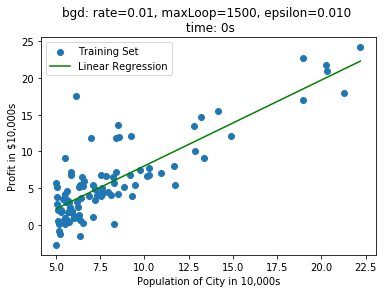

In [11]:
# 绘制拟合曲线
fittingFig = plt.figure()
title = 'bgd: rate=%.2f, maxLoop=%d, epsilon=%.3f \n time: %ds'%(rate,maxLoop,epsilon,timeConsumed)
ax = fittingFig.add_subplot(111, title=title)
trainingSet = ax.scatter(X[:, 1].flatten().A[0], y[:,0].flatten().A[0])

xCopy = X.copy()
xCopy.sort(0)
yHat = xCopy*theta
fittingLine, = ax.plot(xCopy[:,1], yHat, color='g')

ax.set_xlabel('Population of City in 10,000s')
ax.set_ylabel('Profit in $10,000s')

plt.legend([trainingSet, fittingLine], ['Training Set', 'Linear Regression'])
plt.show()

Text(0, 0.5, 'Cost J')

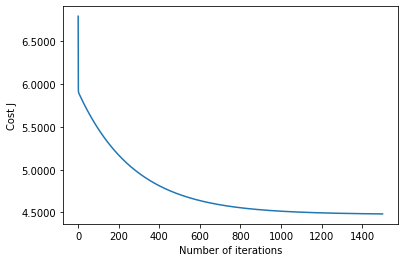

In [12]:
errorsFig = plt.figure()
ax = errorsFig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))

ax.plot(range(len(errors)), errors)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Cost J')

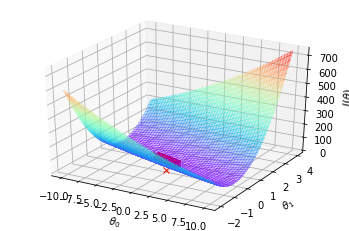

In [13]:
# 绘制能量下降曲面
size = 100
theta0Vals = np.linspace(-10,10, size)
theta1Vals = np.linspace(-2, 4, size)
JVals = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        col = np.matrix([[theta0Vals[i]], [theta1Vals[j]]])
        JVals[i,j] = J(col, X, y)

theta0Vals, theta1Vals = np.meshgrid(theta0Vals, theta1Vals)
JVals = JVals.T
contourSurf = plt.figure()
ax = contourSurf.gca(projection='3d')

ax.plot_surface(theta0Vals, theta1Vals, JVals,  rstride=2, cstride=2, alpha=0.3,
    cmap=cm.rainbow, linewidth=0, antialiased=False)
ax.plot(thetas[0], thetas[1], 'rx')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel(r'$J(\theta)$')

plt.show()

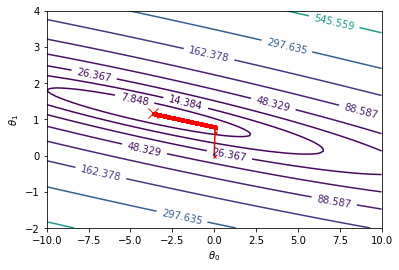

In [14]:
# 绘制能量轮廓
contourFig = plt.figure()
ax = contourFig.add_subplot(111)
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')

CS = ax.contour(theta0Vals, theta1Vals, JVals, np.logspace(-2,3,20))
plt.clabel(CS, inline=1, fontsize=10)

# 绘制最优解
ax.plot(theta[0,0], theta[1,0], 'rx', markersize=10, linewidth=2)

# 绘制梯度下降过程
ax.plot(thetas[0], thetas[1], 'rx', markersize=3, linewidth=1)
ax.plot(thetas[0], thetas[1], 'r-')

plt.show()

# 随机梯度下降图解

In [15]:
rate = 0.01
maxLoop = 100
epsilon =0.01

result, timeConsumed = sgd(rate, maxLoop, epsilon, X, y)
theta, errors, thetas = result

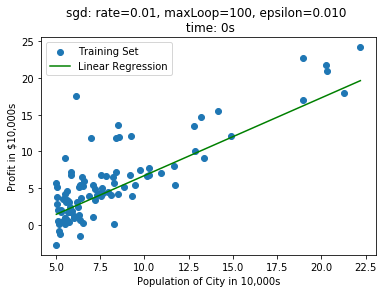

In [16]:
# 绘制拟合曲线
fittingFig = plt.figure()
title = 'sgd: rate=%.2f, maxLoop=%d, epsilon=%.3f \n time: %ds'%(rate,maxLoop,epsilon,timeConsumed)
ax = fittingFig.add_subplot(111, title=title)
trainingSet = ax.scatter(X[:, 1].flatten().A[0], y[:,0].flatten().A[0])

xCopy = X.copy()
xCopy.sort(0)
yHat = xCopy*theta
fittingLine, = ax.plot(xCopy[:,1], yHat, color='g')

ax.set_xlabel('Population of City in 10,000s')
ax.set_ylabel('Profit in $10,000s')

plt.legend([trainingSet, fittingLine], ['Training Set', 'Linear Regression'])
plt.show()

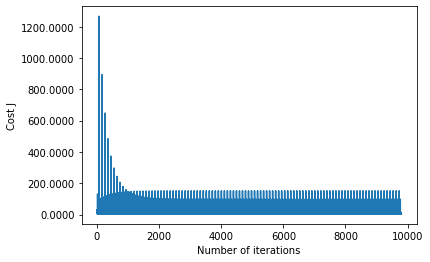

In [19]:
# 绘制误差曲线
errorsFig = plt.figure()
ax = errorsFig.add_subplot(111)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.4f'))

ax.plot(range(len(errors)), errors)
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Cost J')
plt.show()

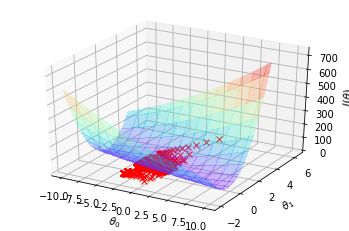

In [20]:
# 绘制能量下降曲面
size = 100
theta0Vals = np.linspace(-10,10, size)
theta1Vals = np.linspace(-2, 4, size)
JVals = np.zeros((size, size))
for i in range(size):
    for j in range(size):
        col = np.matrix([[theta0Vals[i]], [theta1Vals[j]]])
        JVals[i,j] = J(col, X, y)

theta0Vals, theta1Vals = np.meshgrid(theta0Vals, theta1Vals)
JVals = JVals.T
contourSurf = plt.figure()
ax = contourSurf.gca(projection='3d')

ax.plot_surface(theta0Vals, theta1Vals, JVals,  rstride=8, cstride=8, alpha=0.3,
            cmap=cm.rainbow, linewidth=0, antialiased=False)
ax.plot(thetas[0], thetas[1], 'rx')
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')
ax.set_zlabel(r'$J(\theta)$')
plt.show()

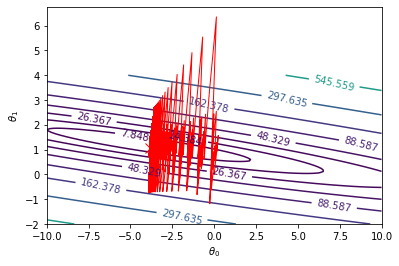

In [21]:
# 绘制能量轮廓
contourFig = plt.figure()
ax = contourFig.add_subplot(111)
ax.set_xlabel(r'$\theta_0$')
ax.set_ylabel(r'$\theta_1$')

CS = ax.contour(theta0Vals, theta1Vals, JVals, np.logspace(-2,3,20))
plt.clabel(CS, inline=1, fontsize=10)

# 绘制最优解
ax.plot(theta[0,0], theta[1,0], 'rx', markersize=10, linewidth=2)

# 绘制梯度下降过程
ax.plot(thetas[0], thetas[1], 'r', linewidth=1)

plt.show()